In [1]:
#### ALL NOTEBOOK SHOULD HAVE SOME VERSION OF THIS #####################################
########################################################################################
%load_ext autoreload
%autoreload 2
import os
import sys

currentdir = os.getcwd()
# go to root directory. change the # of os.path.dirnames based on where currentdir is
parentdir = os.path.dirname(os.path.dirname(currentdir)) 
# chek where I'm at. if I go too far up the tree, go back
if 'Protein-Purification-Model-Public' not in parentdir: parentdir = currentdir
if parentdir not in sys.path: sys.path.insert(0,parentdir)
########################################################################################

In [2]:
import utils
import simple_data_vis as vis
import dab_nn_defs as engine
#import kerastuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# load data from just-private/data
parentdir="."
filename1 = 'mol_res_scan_results_7.csv'
data1 = utils.load_data(parentdir,filename1)

# since currently data is just one big dataframe, select model inputs as X and purity, yield as Y
# should be the same for both datasets
x = [*data1.columns[:2],*data1.columns[4:]]
y = data1.columns[2:4]

In [4]:
data2 = data1.sample(12375)
data3 = data1.sample(8250)
data4 = data1.sample(4125)
data5 = data1.sample(1650)
data6 = data1.sample(165)

In [5]:
def data_pipeline(array, x, y):
    splits = []
    for a in array:
        a = utils.preprocessing([a,], bounds = {'yield':[0,1],'purity':[0,1]})[0]
        train_x, test_x, train_y, test_y = utils.chroma_train_test_split(a, x, y)
        train_x, test_x, scaler_x = utils.preprocessing(
                                    [train_x, test_x], 
                                    standarize = True, 
                                    skip = ['cut 1','cut 2']
                                    )
        splits.append([train_x, train_y])
        splits.append([test_x, test_y])

    return splits

In [6]:
train1, test1, train2, test2, train3, test3, train4, test4, train5, test5, train6, test6 = data_pipeline([data1,data2,data3,data4,data5,data6],x,y)
# could add this bit to data_pipeline
trains = [train1, train2, train3, train4, train5, train6]
tests = [test1, test2, test3, test4, test5, test6]

In [7]:
# define models to test out. a loop makes sense too 
def generate_models(filenames):
    models = []
    for filename in filenames:
        dlr = engine.create_deterministic_linear_regressor(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            name = 'DLR_'+filename[:-4]
        )

        plr = engine.create_probabilistic_linear_regressor(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            name = 'PLR_'+filename[:-4],
        )

        dnn = engine.create_deterministic_nn(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            hidden_units = [16,8,4],
            name = 'DNN_'+filename[:-4]
        )

        pnn = engine.create_probabilistic_nn(
            FEATURE_NAMES = x,
            TARGET_NAMES = y,
            hidden_units = [16,8,4,],
            name = 'PNN_'+filename[:-4],
        )

        models.append([dlr,plr,dnn,pnn])
    return models

all_models = generate_models([filename1,filename1,filename1,filename1,filename1,filename1])

In [8]:
loss_weights = (1/trains[3][1].mean().div(trains[3][1].mean().max())).round(2).to_dict() 
loss_weights

{'yield': 1.92, 'purity': 1.0}

In [9]:
# train all the models under the same conditions
learning_rate = 0.01
epochs = 100
optimizer = 'Adam' # change manually or come up with dictionary?
losses = ['mean_squared_error', engine.negative_loglikelihood]*2
loss_weights = (1/trains[0][1].mean().div(trains[0][1].mean().max())).round(2).to_dict() 
histories = {}

for models, train, test, filename in zip(all_models, trains, tests, [filename1,filename1,filename1,filename1,filename1,filename1]):
    for m,l in zip(models,losses):
        histories[utils.get_model_name(m,filename)] = engine.run_experiment(
            model = m, 
            loss = {y[0]:l,y[1]:l},
            loss_weights = loss_weights,
            optimizer = tf.keras.optimizers.Adam,
            learning_rate = learning_rate,
            num_epochs = epochs,
            train_dataset = train, 
            test_dataset = test,
            verbose = 0,
            log = 0
            )

settings = {'learning_rate' : learning_rate,
            'epochs' : epochs,
            'optimizer': optimizer,
            'loss_weights': loss_weights,
            'dataset' : filename1+'\n'+filename1+'\n'+filename1+'\n'+filename1+'\n'+filename1+'\n'+filename1}

Start training the model DLR_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.789
Test MSE: 0.865
Start training the model PLR_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.811
Test MSE: 0.98
Start training the model DNN_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.013
Test MSE: 0.018
Start training the model PNN_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.021
Test MSE: 0.031
Start training the model DLR_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.744
Test MSE: 0.689
Start training the model PLR_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.799
Test MSE: 0.732
Start training the model DNN_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.011
Test MSE: 0.011
Start training the model PNN_mol_res_scan_results_7 ...
Evaluating model performance...
Train MSE: 0.022
Test MSE: 0.021
Start training the model DLR_mol_

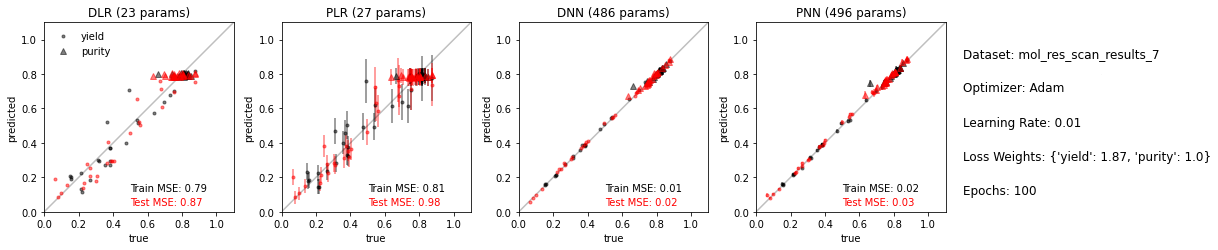

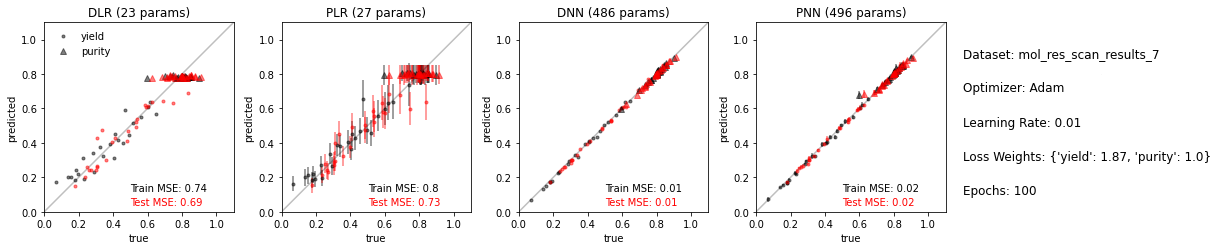

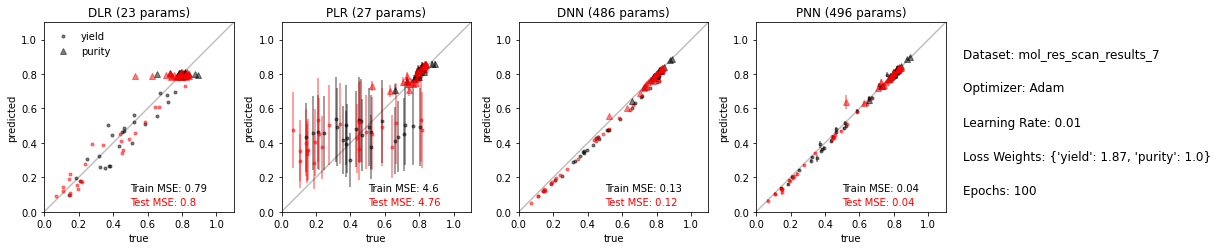

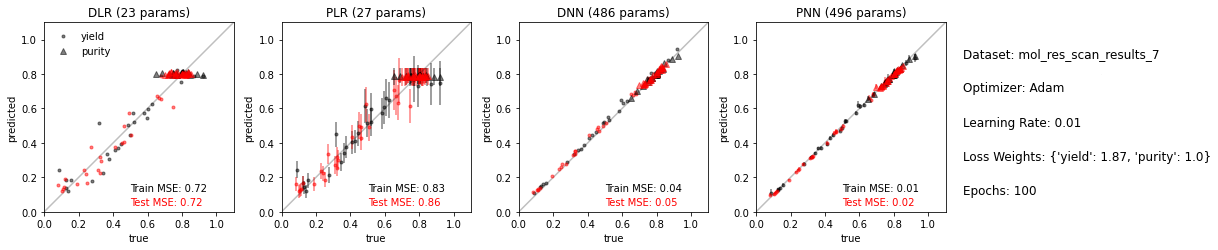

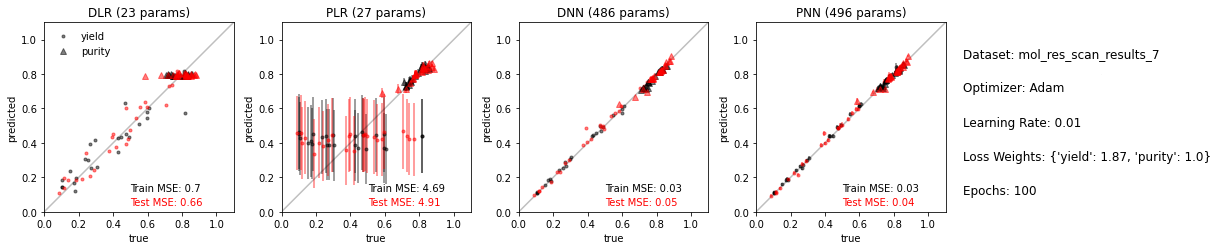

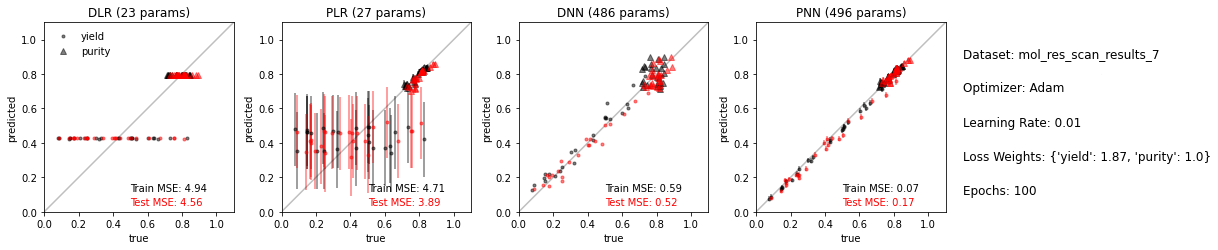

In [10]:
# check model predictions
settings['dataset'] = filename1
vis.scatter_hats(all_models[0], trains[0], tests[0], settings, N = 25)
settings['dataset'] = filename1
vis.scatter_hats(all_models[1], trains[1], tests[1], settings, N = 25)
settings['dataset'] = filename1
vis.scatter_hats(all_models[2], trains[2], tests[2], settings, N = 25)
settings['dataset'] = filename1
vis.scatter_hats(all_models[3], trains[3], tests[3], settings, N = 25)
settings['dataset'] = filename1
vis.scatter_hats(all_models[4], trains[4], tests[4], settings, N = 25)
settings['dataset'] = filename1
vis.scatter_hats(all_models[5], trains[5], tests[5], settings, N = 25)

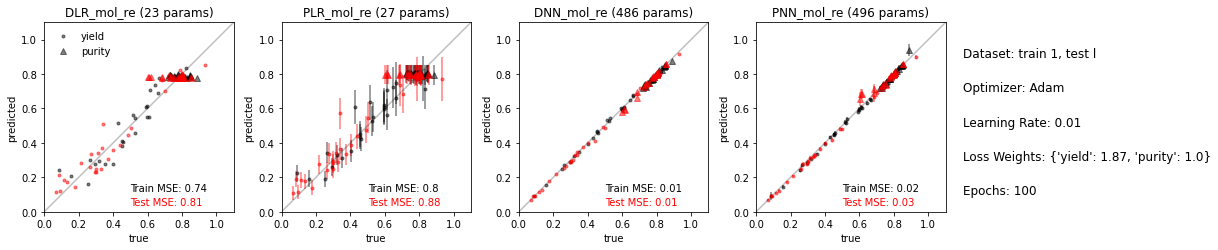

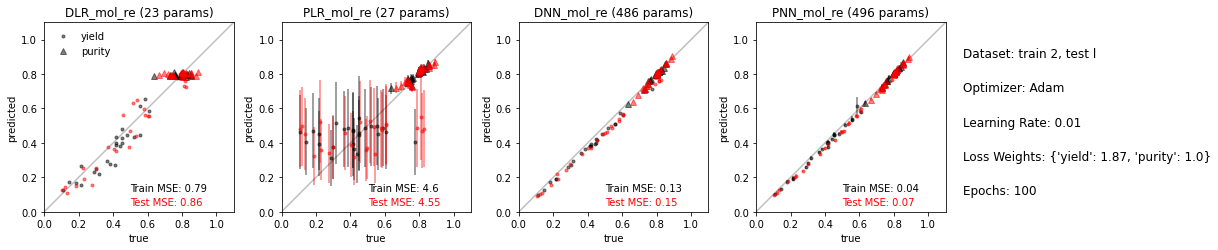

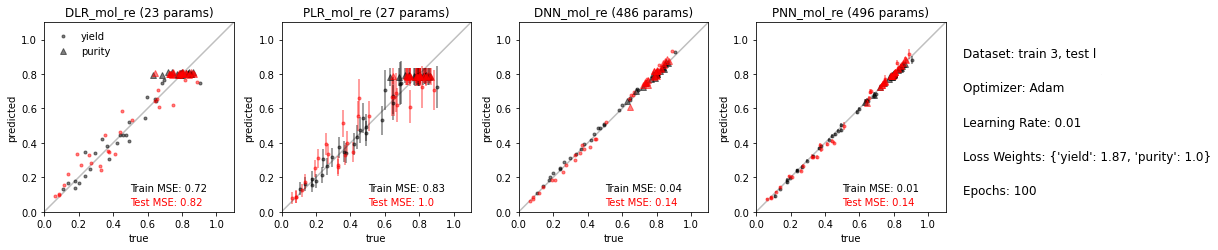

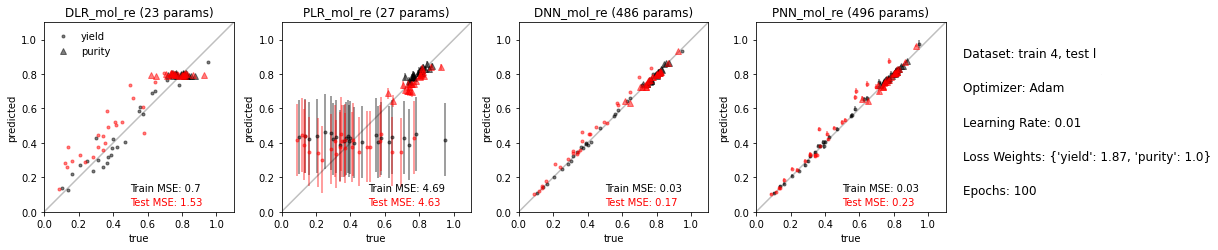

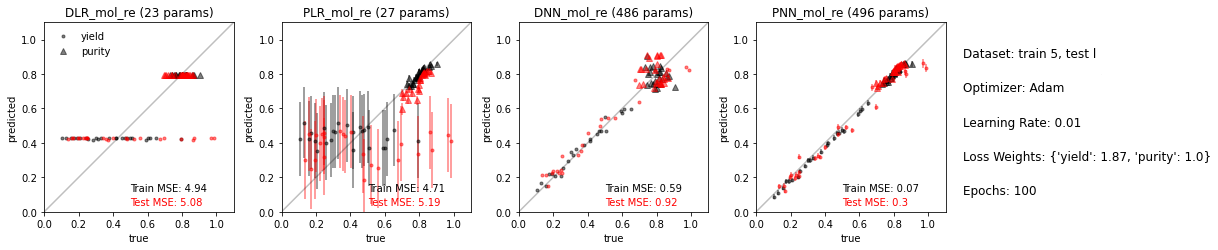

In [11]:
settings['dataset'] = 'train 1, test large'
vis.scatter_hats(all_models[1], trains[1], tests[0], settings, N = 25)
settings['dataset'] = 'train 2, test large'
vis.scatter_hats(all_models[2], trains[2], tests[0], settings, N = 25)
settings['dataset'] = 'train 3, test large'
vis.scatter_hats(all_models[3], trains[3], tests[0], settings, N = 25)
settings['dataset'] = 'train 4, test large'
vis.scatter_hats(all_models[4], trains[4], tests[0], settings, N = 25)
settings['dataset'] = 'train 5, test large'
vis.scatter_hats(all_models[5], trains[5], tests[0], settings, N = 25)